# Running simulations

import required modules and classes

In [1]:
import numpy as np
from pydemic.models.seirpp import SEIRPlusPlusSimulation
from pydemic.containment import MitigationModel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 16

Specify a state. The current case data, total population, and age distribution models are then obtained.

In [2]:
state = "Illinois"
from pydemic.data import united_states
data = united_states.get_case_data(state)
total_population = united_states.get_population(state)
age_distribution = united_states.get_age_distribution()

Choose simulation time range.
The initial time is specified as a non-integer number of days from 2020/1/1
(as obtained from fitting), but the final day can be expressed as a date
tuple (which is suitably converted by the `days_from` function).

In [3]:
from pydemic import days_from
tspan = (54.873, days_from((2020, 11, 1)))

Specify model parameters.

In [4]:
parameters = dict(
    r0=3.055,
    serial_k=1.5,
    serial_mean=4.,
    p_symptomatic=1.0,
    incubation_k=3.,
    incubation_mean=5.,
    p_positive=0.357,
    positive_k=1.,
    positive_mean=10.642,
    p_dead=0.555,
    icu_k=1.,
    icu_mean=9.489,
    dead_k=2.17,
    dead_mean=12.81,
)

Specify a mitigation model via a list of time (in days from 2020/1/1) and factors on those days.

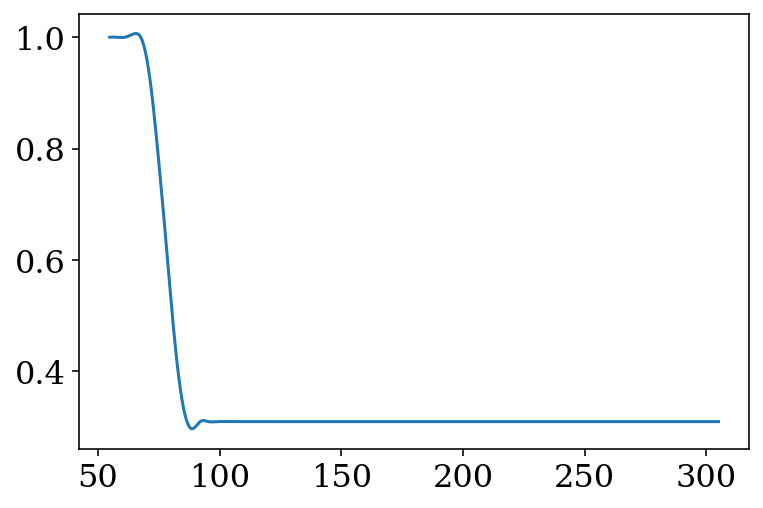

In [5]:
times = [70, 85]
factors = [1, .31] 
mitigation = MitigationModel(*tspan, times, factors)
fig, ax = plt.subplots()
_t = np.linspace(*tspan, 1000)
ax.plot(_t, mitigation(_t))

Initialize and run the simulation.

In [6]:
sim = SEIRPlusPlusSimulation(mitigation=mitigation, **parameters)

initial_cases = 10
y0 = sim.get_y0(total_population, initial_cases, age_distribution)

result = sim(tspan, y0, .05)

Plot the results.

In [7]:
plot_compartments = [
#     'susceptible',
    'infected',
#     'symptomatic',
    'positive',
#     'critical_dead',
    'dead',
#     'population'
    'hospital_removed',
]

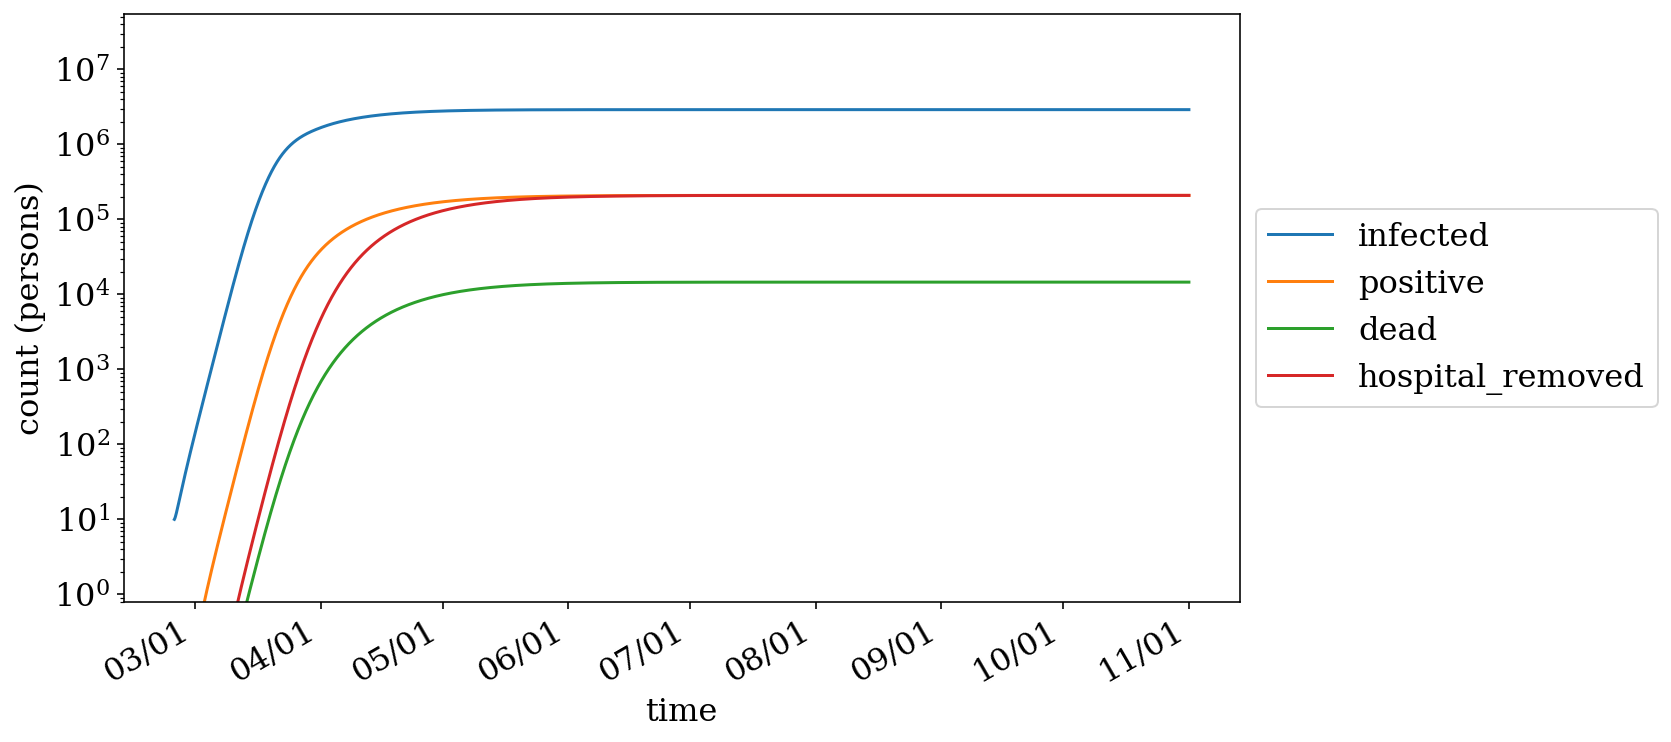

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

from pydemic import days_to_dates

for name in plot_compartments:
    ax.plot(days_to_dates(result.t),
            (result.y[name].sum(axis=1)),
            label=name)

ax.plot()
# plot on y log scale
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)

# plot x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()

# create legend
ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_xlabel('time')
ax.set_ylabel('count (persons)');

Plot the death counts against the simulation result.
The containment model is plotted on the bottom panel.

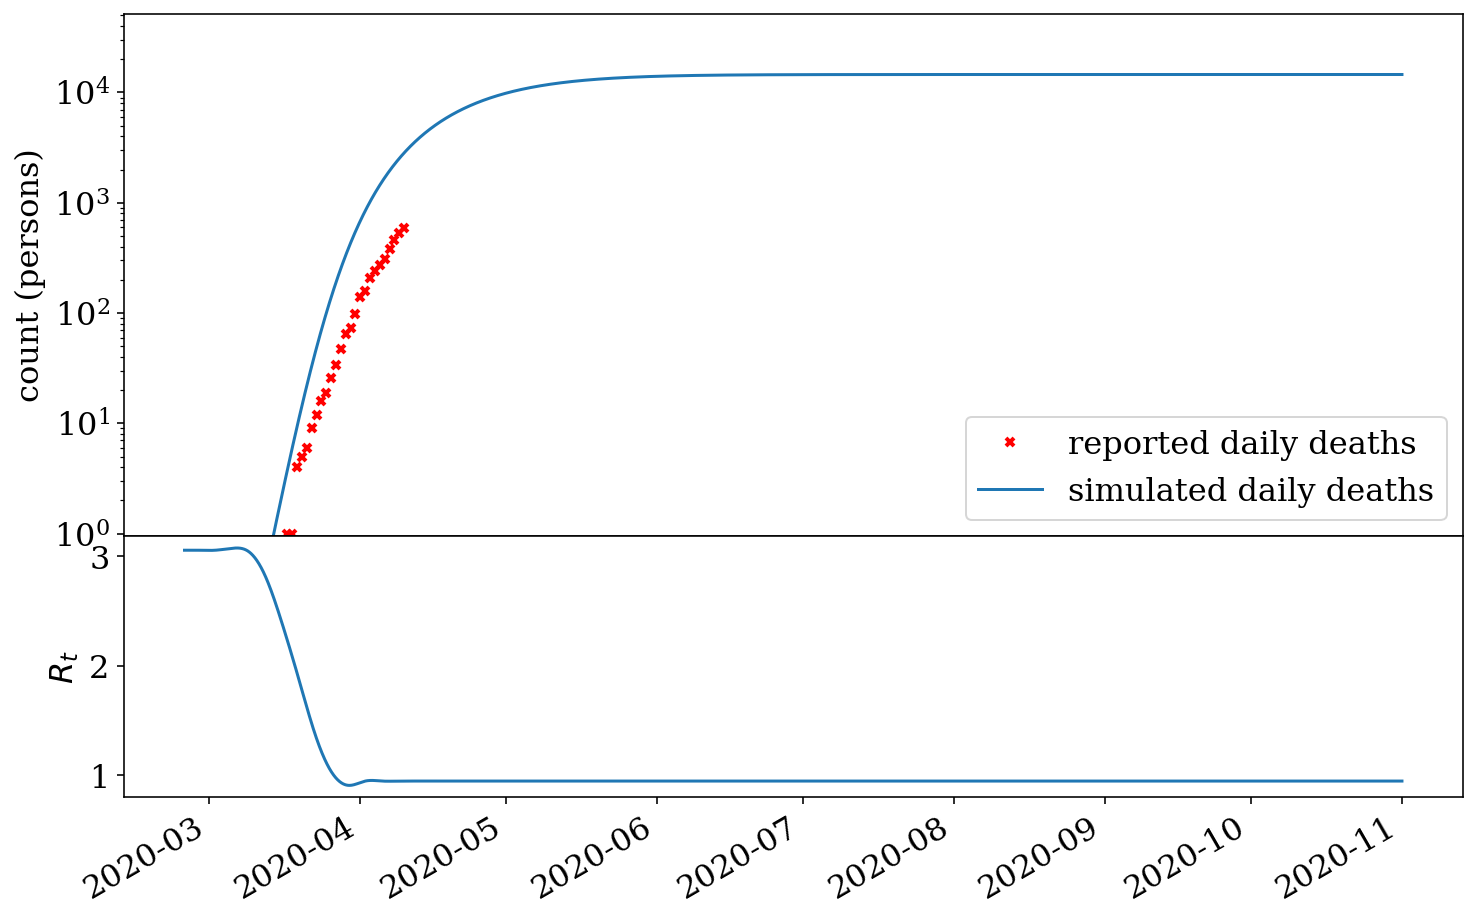

In [9]:
fig = plt.figure(figsize=(12, 8))

import matplotlib.gridspec as gridspec
gspec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax = [fig.add_subplot(gspec[:2,0]), fig.add_subplot(gspec[2,0])]

ax[0].semilogy(days_to_dates(data.t), data.y['dead'],
            'x', c='r', ms=4, markeredgewidth=2,
            label='reported daily deaths')

ax[0].semilogy(days_to_dates(result.t), result.y['dead'].sum(axis=1),
            '-', linewidth=1.5, label='simulated daily deaths')

ax[1].plot(days_to_dates(result.t), parameters['r0'] * mitigation(result.t),
            '-', linewidth=1.5)

ax[0].set_ylabel("count (persons)")
ax[1].set_ylabel(r'$R_t$')
ax[0].set_ylim(.95, .5 * ax[0].get_ylim()[1])
ax[0].legend()

import matplotlib.dates as mdates
fig.autofmt_xdate()
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig('seirpp_best_fit.png')